In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Qiskit stuff
from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import QuantumRegister, Qubit, Gate, ClassicalRegister
from qiskit.aqua.components.oracles import Oracle, TruthTableOracle
from qiskit.quantum_info import Statevector

from qiskit.test.mock import FakeYorktown

# Transpiling stuff
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap
from qiskit.transpiler import CouplingMap, Layout

#import utils
from collections import OrderedDict
import math
import numpy as np

# Import general libraries (needed for functions)
import time

# Import Qiskit classes
import qiskit
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
!pip install mitiq
import mitiq

  Using cached numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.7/site-packages/numpy-1.19.2.dist-info/RECORD'



<AccountProvider for IBMQ(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main')>
ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_valencia
ibmq_armonk
ibmq_athens
ibmq_rome
ibmq_santiago
ibmq_bogota
ibmq_casablanca


<IBMQBackend('ibmq_casablanca') from IBMQ(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main')>

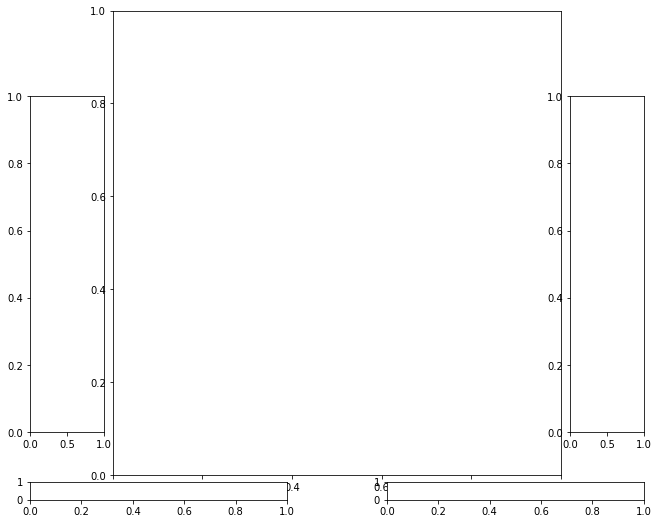

In [3]:
# Loading your IBM Q account(s)
provider = IBMQ.get_provider(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main') 
print(provider)
backends = provider.backends()
for backend in backends:
    print(backend.name())

backend = provider.backends(name = 'ibmq_casablanca')[0]
properties = backend.properties() 
coupling_map = backend.configuration().coupling_map
backend

# A micro quantum walk

The objective of this notebook is to explain how to perform a very small quantum walk over a space of only two positions for the rotation angle of a dipeptide. The objective is being able to implement it in real hardware and be able to measure the result without too much noise.
The first thing we do is loading the deltas of energies, although in the end we will only use one of those, the one corresponding to the angle we are interested in

In [4]:
# Loading the energies
import json
with open('delta_energies_glycylglycine_1_hardware.json') as json_file:
    data = json.load(json_file)

deltas_dictionary = data['deltas']
deltas_dictionary = OrderedDict(sorted(deltas_dictionary.items()))
print(len(deltas_dictionary))
deltas = {}
for (key,value) in deltas_dictionary.items():
    deltas[key[:3]] = value

print('Deltas of energy ------------------')
for (key,value) in deltas.items():
    print(key, value)

16
Deltas of energy ------------------
000 0.27042123529724904
001 26.032737333542684
010 0.24282032166763656
011 -26.032737333542684
100 -0.27042123529724904
101 26.00513641991307
110 -0.24282032166763656
111 -26.00513641991307


What angle do we want to walk over? We can choose $\phi$ or $\psi$, to calculate $\Delta E$. Notice that since we are in the hardware option, the index 00 will be the minimum of energy and thus both `deltas['000']>0` and `deltas['001']>0`.
Let us now create a function that returns the circuit, depending on the angle, the number of W, `n_W`, and the beta schedule, $\beta$`_schedule`.

In [5]:
def circuit_generator(angle = '𝜙', 𝛽_schedule = [0, 0.1, 1, 10, 10000]):
    '''Returns a circuit performing the quantum walk with the 𝛽_schedule over the chosen angle'''   
    
    # Then calculate the delta of energy that is relevant
    if angle == '𝜙':
        Δ_𝐸 = deltas['000']
    elif angle == '𝜓':
        Δ_𝐸 = deltas['001']
    
    # Define a function that calculates the rotation angle, and then vectorize it
    def calc_angle(Δ_𝐸, 𝛽):
        probability = math.exp(-𝛽 * Δ_𝐸)
        angle = math.pi - 2 * math.asin(math.sqrt(probability))
        return angle
        
    calc_angles = np.vectorize(calc_angle)
    angles = calc_angles(Δ_𝐸, 𝛽_schedule)
    
    # Let us now define the Walk step 𝑊=𝑅 𝑉^† 𝐵^† 𝐹 𝐵 𝑉. However, in our case we do not have to prepare V
    def W_step(qc: QuantumCircuit, angle_reg: QuantumRegister, coin_reg: QuantumRegister, angle: float, last_W: bool):
        # First prepare the coin
        qc.x(coin_reg)
        
        qc.x(angle_reg)
        qc.cu(-angle,-math.pi/2,math.pi/2,0,angle_reg,coin_reg)
        qc.x(angle_reg)
        
        # Then perform the move with move with the probability given by coin_reg
        qc.cx(coin_reg,angle_reg)
        
        if not last_W:
            # Then uncompute the move 
            qc.x(angle_reg)
            qc.cu(angle,-math.pi/2,math.pi/2,0,angle_reg,coin_reg)
            qc.x(angle_reg)

            ## qc.x(coin_reg)

            # Finally, perform the reflection over the state |0> in the coin
            ## qc.x(coin_reg)
            qc.z(coin_reg)
            qc.x(coin_reg)
        
    # Therefore the circuit is the following
    coin_reg = QuantumRegister(1, name = 'coin')
    angle_reg = QuantumRegister(1, name = 'angle')
    bit_reg = ClassicalRegister(1, name = 'bit')
    qc = QuantumCircuit(coin_reg, angle_reg, bit_reg)
    
    # Initialization
    qc.h(angle_reg)
    
    # Perform the various steps
    for i in range(len(𝛽_schedule)):
        W_step(qc, angle_reg, coin_reg, angles[i], i == len(𝛽_schedule)-1)
        
    # Measurement
    qc.measure(angle_reg, bit_reg)
    
    # Transpiling and optimization
    layout = {5: coin_reg[0], 6: angle_reg[0]}
    qc = transpile(qc, seed_transpiler=1, optimization_level=1, basis_gates = ['u1', 'u2', 'u3', 'cx'])
    print('Before optimization--------')
    print('gates = ', qc.count_ops())
    print('depth = ', qc.depth())
    qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=3, initial_layout=layout, basis_gates = ['u1', 'u2', 'u3', 'cx'])
    print('After optimization--------')
    print('gates = ', qc.count_ops())
    print('depth = ', qc.depth())
    
    return qc


We will see that the circuit optimizer is in fact so powerful that for any reasonable number of steps, the circuit will have depth 6 if the number of steps is even, and 8 if it is odd

Before optimization--------
gates =  OrderedDict([('u3', 21), ('cx', 19), ('u1', 4), ('u2', 3), ('measure', 1)])
depth =  39
After optimization--------
gates =  OrderedDict([('u3', 6), ('cx', 3), ('u2', 2), ('measure', 1)])
depth =  8


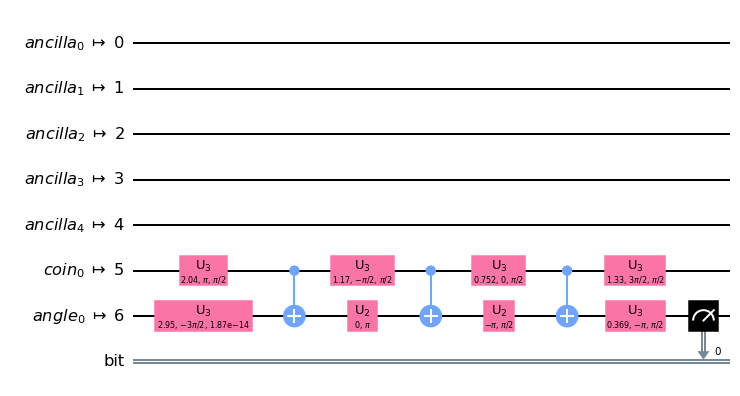

In [6]:
qc = circuit_generator(angle = '𝜙', 𝛽_schedule = [0,0.1,1,10,1000])
qc.draw('mpl')

Now, we would like to perform some noise mitigation to be able to correct the data. Let us start with measurement error mitigation from Qiskit. To do that we need to first calibrate the filter.

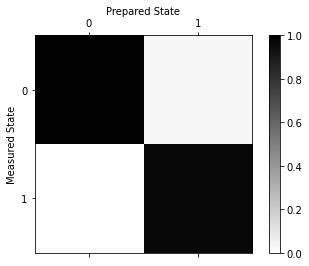

In [12]:
qr = qiskit.QuantumRegister(1)
qubit_list = [0]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr = qr, circlabel='mcal')

layout = {6: qr[0]}


# Execute the calibration circuits without noise
job = qiskit.execute(meas_calibs, backend=backend, shots=1024, initial_layout=layout)
cal_results = job.result()

# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
meas_filter = meas_fitter.filter

# Plot the calibration matrix
meas_fitter.plot_calibration()

In [13]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

# What is the measurement fidelity of Q0?
print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
    label_list = [['0','1'],['0','1']]))

Average Measurement Fidelity: 0.978516
Average Measurement Fidelity of Q0: 1.000000


Next we would like to use some mitigation that also takes into account the error from the gates. We will be using mitiq: https://mitiq.readthedocs.io/en/stable/guide/guide-ibmq-backends.html

In [9]:
def backend_executor(circuit: QuantumCircuit, shots: int = 8192) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    # (1) Add measurements to the circuit
    #circuit.measure(circuit.qregs[0], circuit.cregs[0])

    # (2) Run the circuit
    job = qiskit.execute(
        experiments=circuit,
        backend=backend,
        optimization_level=0,  # Important!
        shots=shots
    )

    # (3) Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    print(counts)
    if counts.get("0") is None:
        expectation_value = 0.
    else:
        expectation_value = counts.get("0") / shots
    return expectation_value

Let us run some experiments

In [10]:
# Noiseless perfect simulation
aerbackend = Aer.get_backend('statevector_simulator')
backend_options = {"method" : "statevector"}
experiment = execute(qc, aerbackend, backend_options=backend_options)
state_vector = Statevector(experiment.result().get_statevector(qc))

probabilities = state_vector.probabilities([0])
noiseless_counts = {}
noiseless_counts['0'] = float(probabilities[0])
noiseless_counts['1'] = float(probabilities[1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  after removing the cwd from sys.path.


In [17]:
# Running the circuit in real hardware
job = execute(qc, backend, shots=8192)
results = job.result()
raw_counts = results.get_counts()
running_time = job.result().time_taken
print('running_time',running_time)

# Results with measurement mitigation
# Get the filter object
meas_filter = meas_fitter.filter
# Results with mitigation
mitigated_results = meas_filter.apply(results)
mm_counts = mitigated_results.get_counts()

# Results with gate error mitigation
gm_counts = {}
gm_counts['0'] = mitiq.execute_with_zne(qc, backend_executor)
gm_counts['1'] = 1 - gm_counts['0']

running_time 32.21305775642395
{'0': 6799, '1': 1393}
{'0': 6824, '1': 1368}
{'0': 6450, '1': 1742}


Finally we can plot it

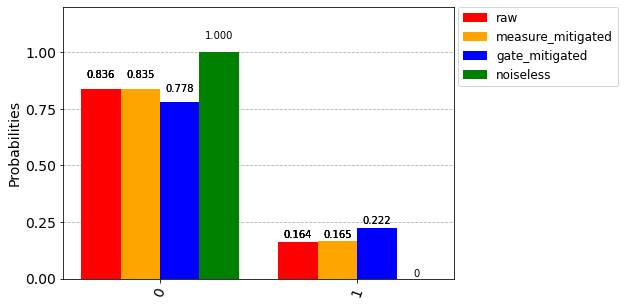

In [18]:
plot = plot_histogram([raw_counts, mm_counts, gm_counts,noiseless_counts], 
               legend=['raw', 'measure_mitigated','gate_mitigated','noiseless'], color = ['red','orange','blue','green'])

plot.savefig('histogram_hardware_GG1.png')
plot

In [ ]:
qiskit.__qiskit_version__
!python -V